In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras import initializers
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras

In [24]:
K.image_data_format()

'channels_last'

In [25]:
# Load npz file containing image arrays
x_npz = np.load("x_images_arrays.npz")
x = x_npz['arr_0']
# Load binary encoded labels for Lung Infiltrations: 0=Not_infiltration 1=Infiltration
y_npz = np.load("y_disease_labels.npz")
y = y_npz['arr_0']

In [53]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_valtest, y_train, y_valtest = train_test_split(x,y, test_size=0.2, random_state=1, stratify=y)

# Second split the 20% into validation and test sets
X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=1, stratify=y_valtest)

In [27]:
print(np.array(X_train).shape)
print(np.array(X_val).shape)
print(np.array(X_test).shape)

(3621, 128, 128, 3)
(453, 128, 128, 3)
(453, 128, 128, 3)


In [28]:
y_train = keras.utils.to_categorical(y_train, 8)
y_test = keras.utils.to_categorical(y_test, 8)
y_val = keras.utils.to_categorical(y_val, 8)

In [29]:
img_width, img_height = 128, 128
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
epochs = 10
batch_size = 16

In [30]:
model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(img_width, img_height, 3)))
# model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
# model.add(BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
# model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation = 'relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(8, activation = 'softmax'))
# model.add(layers.BatchNormalization())

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001),
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
__________

## Data augmentation

In [31]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, rotation_range=30)
valtest_datagen = ImageDataGenerator(rescale=1. / 255)

In [32]:
train_generator = train_datagen.flow(np.array(X_train), y_train, batch_size=batch_size)
validation_generator = valtest_datagen.flow(np.array(X_val), y_val, batch_size=batch_size)
test_generator = valtest_datagen.flow(np.array(X_test), y_test, batch_size=batch_size)

In [33]:
model_history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/10
226/226 [==============================] - 161s 714ms/step - loss: 1.2911 - acc: 0.6683 - val_loss: 1.2666 - val_acc: 0.6733
Epoch 2/10
226/226 [==============================] - 156s 688ms/step - loss: 1.2487 - acc: 0.6736 - val_loss: 1.2186 - val_acc: 0.6733
Epoch 3/10
226/226 [==============================] - 154s 679ms/step - loss: 1.2362 - acc: 0.6730 - val_loss: 1.2305 - val_acc: 0.6733
Epoch 4/10
226/226 [==============================] - 154s 682ms/step - loss: 1.2309 - acc: 0.6717 - val_loss: 1.2216 - val_acc: 0.6733
Epoch 5/10
226/226 [==============================] - 145s 641ms/step - loss: 1.2296 - acc: 0.6711 - val_loss: 1.2156 - val_acc: 0.6733
Epoch 6/10
226/226 [==============================] - 149s 658ms/step - loss: 1.2009 - acc: 0.6755 - val_loss: 1.2125 - val_acc: 0.6733
Epoch 7/10
226/226 [==============================] - 158s 698ms/step - loss: 1.2198 - acc: 0.6709 - val_loss: 1.1904 - val_acc: 0.6733
Epoch 8/10
226/226 [============================

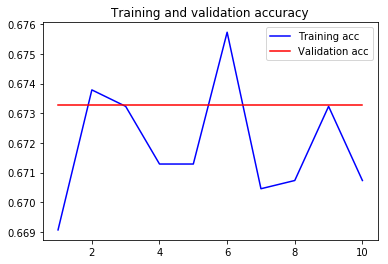

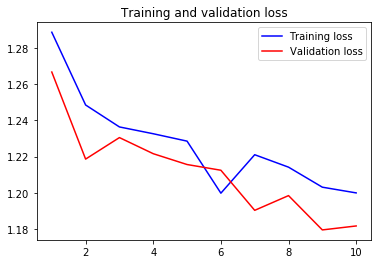

In [38]:
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Trial 2: Reduce Learning Rate

In [34]:
model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(img_width, img_height, 3)))
# model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
# model.add(BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
# model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation = 'relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(8, activation = 'softmax'))
# model.add(layers.BatchNormalization())

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001),
    metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
__________

In [41]:
models = models.Sequential()

models.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(img_width, img_height, 3)))
# model.add(BatchNormalization())

models.add(MaxPooling2D((2, 2)))

models.add(Conv2D(64, (3, 3), activation = 'relu'))
# model.add(BatchNormalization())

models.add(layers.MaxPooling2D((2, 2)))

models.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
# model.add(layers.BatchNormalization())

models.add(layers.MaxPooling2D((2, 2)))

models.add(layers.Flatten())
models.add(layers.Dropout(0.2))
models.add(layers.Dense(64, activation = 'relu'))
# model.add(layers.BatchNormalization())
models.add(layers.Dropout(0.2))
models.add(layers.Dense(8, activation = 'softmax'))
# model.add(layers.BatchNormalization())

models.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0000001),
    metrics=['acc'])

models.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
__________

In [43]:
models_history = models.fit_generator(
    train_generator, 
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
227/227 [==============================] - 166s 732ms/step - loss: 1.8498 - acc: 0.5174 - val_loss: 1.5902 - val_acc: 0.6733
Epoch 2/10
227/227 [==============================] - 180s 794ms/step - loss: 1.4351 - acc: 0.6716 - val_loss: 1.3039 - val_acc: 0.6733
Epoch 3/10
227/227 [==============================] - 170s 748ms/step - loss: 1.2799 - acc: 0.6729 - val_loss: 1.2453 - val_acc: 0.6733
Epoch 4/10
227/227 [==============================] - 157s 691ms/step - loss: 1.2546 - acc: 0.6716 - val_loss: 1.2333 - val_acc: 0.6733
Epoch 5/10
227/227 [==============================] - 176s 777ms/step - loss: 1.2392 - acc: 0.6722 - val_loss: 1.2289 - val_acc: 0.6733
Epoch 6/10
227/227 [==============================] - 161s 710ms/step - loss: 1.2390 - acc: 0.6722 - val_loss: 1.2259 - val_acc: 0.6733
Epoch 7/10
  7/227 [..............................] - ETA: 2:58 - loss: 1.3368 - acc: 0.6429

KeyboardInterrupt: 

In [49]:
tbcallback = keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=0, batch_size=32, 
                                         write_graph=True, write_images=True)

In [51]:
tbcallback

In [52]:
models_history = models.fit_generator(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    callbacks= [tbcallback]
)

Epoch 1/10
227/227 [==============================] - 172s 759ms/step - loss: 1.2398 - acc: 0.6722 - val_loss: 1.2243 - val_acc: 0.6733
Epoch 2/10
227/227 [==============================] - 157s 693ms/step - loss: 1.2348 - acc: 0.6735 - val_loss: 1.2238 - val_acc: 0.6733
Epoch 3/10
227/227 [==============================] - 165s 727ms/step - loss: 1.2436 - acc: 0.6722 - val_loss: 1.2224 - val_acc: 0.6733
Epoch 4/10
227/227 [==============================] - 164s 724ms/step - loss: 1.2375 - acc: 0.6716 - val_loss: 1.2223 - val_acc: 0.6733
Epoch 5/10
227/227 [==============================] - 166s 733ms/step - loss: 1.2281 - acc: 0.6729 - val_loss: 1.2218 - val_acc: 0.6733
Epoch 6/10
227/227 [==============================] - 176s 777ms/step - loss: 1.2398 - acc: 0.6716 - val_loss: 1.2212 - val_acc: 0.6733
Epoch 7/10
227/227 [==============================] - 167s 734ms/step - loss: 1.2272 - acc: 0.6722 - val_loss: 1.2210 - val_acc: 0.6733
Epoch 8/10
227/227 [============================

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio='auto')
X_trainRos, y_trainRos = ros.fit_sample(X_train_reshape, y_train)
X_testRos, y_testRos = ros.fit_sample(X_test_reshape, y_test)

y_trainRosHot = keras.utils.to_categorical(y_trainRos, num_classes = 8)
y_testRosHot = keras.utils.to_categorical(y_testRos, num_classes = 8)